# Image segmentation

Code developed by Marcelo Ferrer and Aymen Merchaoui

Development to segment automatically mouse embryos from microscopy images [source](https://bbbc.broadinstitute.org/BBBC003). The dataset contains 15 grayscale images with their corresponding binary masks.

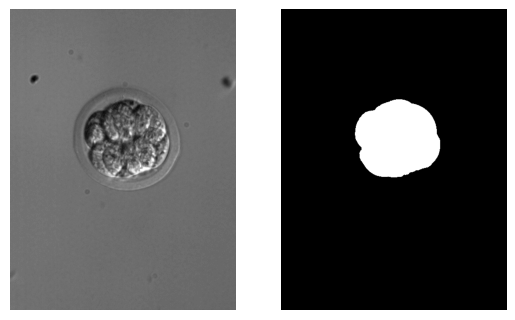

In [2]:
import matplotlib.pyplot as plt

# Aux function that shows an image and its corresponding mask in the same figure
def show(image, mask, title=None):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(image, cmap="gray")
    ax[0].axis('off')
    if title is not None:
        fig.suptitle(title)
    ax[1].imshow(mask, cmap="gray")
    ax[1].axis('off')
    plt.show()

im = plt.imread("images/7_19_M1E18.tif")
mask = plt.imread("masks/7_19_M1E18.tif")
show(im,mask)

## UNet
We are going to segment the images using an UNet. To this end, we are going to follow the next steps:

1. Define the net architecture
2. Generate a training and a validation dataset
3. Train the net
4. Validate the results


In [3]:
import torch

if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"
    
device = torch.device(device_name)
print(f"Code runs in {device}")

Code runs in cpu


### Step 1: Model architecture

In [4]:
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
    )   


class UNet(nn.Module):

    def __init__(self, input_channels, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(input_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

### Step 2: Load the data

In [5]:
from torch.utils.data import Dataset, DataLoader 
import torchvision.transforms as transforms
import glob
import os
import numpy as np
import random


class EmbryoDataset(Dataset):
    
    def __init__(self, image_path, mask_path, transform = None):
        super().__init__()
        # Load all the filenames with extension tif from the image_path directory
        self.img_files = glob.glob(os.path.join(image_path,'*.tif'))
        self.mask_files = []
        # We asume that each image has the same filename as its corresponding mask
        # but it is stored in another directory (mask_path)
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(mask_path,os.path.basename(img_path)))
                
        self.transform = transform

    # Returns both the image and the mask
    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            image = plt.imread(img_path)
            mask = plt.imread(mask_path)
            if len(mask.shape) > 2:
                # Some tiff images in this dataset has 4 identical channels :S
                mask = mask[:,:,0]
            
            # Apply the defined transformations to both image and mask
            if self.transform is not None:
                seed = np.random.randint(2147483647) # make a seed with numpy generator 
                random.seed(seed) # apply this seed to image transforms
                torch.manual_seed(seed) 
                image = self.transform(image)
                random.seed(seed) # apply the same seed to mask transforms
                torch.manual_seed(seed) 
                mask = self.transform(mask)
            else:
                t2 = transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.ToTensor()])
                image = t2(image)
                mask = t2(mask)
                
                
            return image, mask

    def __len__(self):
        return len(self.img_files)


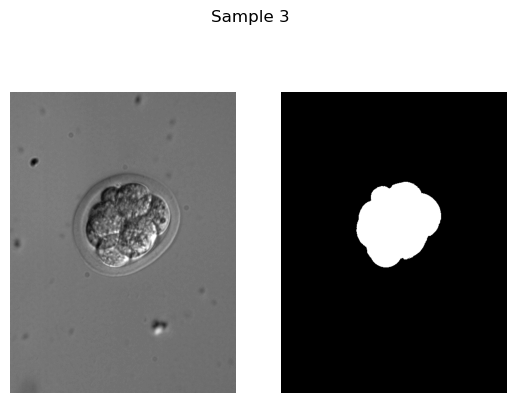

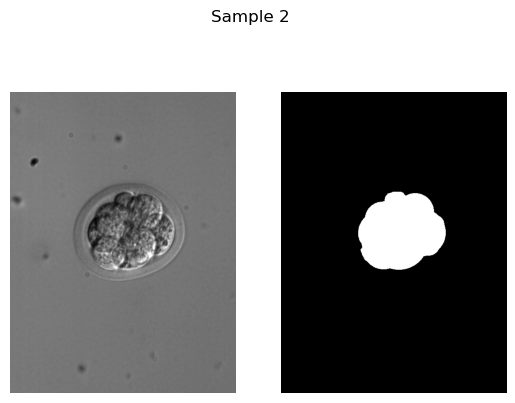

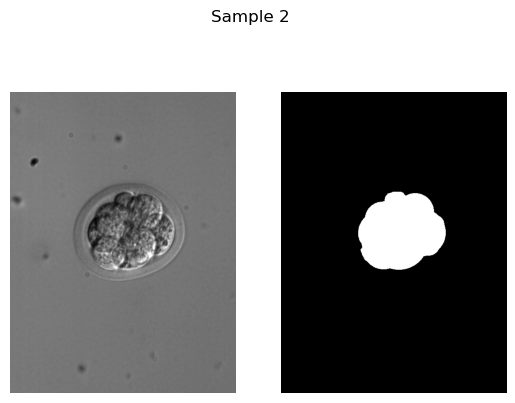

In [6]:
# Load some samples
simple_dataset = EmbryoDataset("images", "masks")
nsamples = 3
for _ in range(nsamples):
    idx = np.random.randint(0, len(simple_dataset))
    im, mask = simple_dataset[idx]
    show(im.squeeze(), mask.squeeze(), title=f"Sample {idx}")
    
# Divide the dataset into training and validation datasets
train_dataset, valid_dataset = torch.utils.data.random_split(simple_dataset, [12, 3])

## Step 3: Training

Once the training and validation datasets are created, the next step is training.

In [7]:
# Hyperparameters
LR = 0.0001
N_INPUT_CHANNELS = 1
N_CLASSES = 1
THRESHOLD = 0.5
BATCH_SIZE = 2
EPOCHS = 50

In [8]:
# Get the segmentation mask of an image
def get_segmentation_masks(outputs, threshold=0.3):
    # Apply sigmoid function to the outputs to have values between 0 and 1
    probs = torch.sigmoid(outputs)
    # Applies a threshold threshold to the predicted probabilities
    # If the probabilities are greater than the threshold are set to 1, the rest is set to 0.
    masks = (probs > threshold) * 1.0
    # Return the generated binary mask
    return masks

In [9]:
# Function to calculate the IoU between a predicted mask and the mask target
def compute_iou(outputs_mask, targets):
    intersection = np.logical_and(outputs_mask.to(torch.int64) , targets.to(torch.int64) )
    union = np.logical_or(outputs_mask.to(torch.int64) , targets.to(torch.int64) )

    return (intersection.sum(dim=(1,2,3)) / union.sum(dim=(1,2,3))).sum()

In [10]:
# Function to train the model. It uses IoU as accuracy measure
def train_model(model, train_dataset, valid_dataset, device,
                optimizer, 
                f_loss,
                batch_size=128, 
                num_epochs=20,
                output_filename='trained-unet.pt',
                early_stopping=5):

    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    train_losses = []
    val_losses = []
    train_iou =[]
    val_iou = []
    best_loss = 0
    not_improve = 0

    for n_epoch in range(0,num_epochs):
        count = 0
        total_loss = 0.0
        total_iou = 0.0

        ### Indicates that the model is used for training
        model.train()
        
        ### Loop through the batches
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = f_loss(outputs, targets)

            # Accumulate the number of processed samples
            count += inputs.shape[0]

            # Accumulate the total loss
            total_loss += inputs.shape[0] * loss.item()

            # Compute IOU
            outputs_mask=get_segmentation_masks(outputs, 0.1)
            iou = compute_iou(outputs_mask, targets)
            total_iou += iou.sum()

            # Backpropagate the error to change the model weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_losses.append(total_loss/count)
        train_iou.append(total_iou/count)

        ### after each train, test the network with the validation set
        count = 0
        total_loss = 0.0
        total_iou = 0.0
        
        ### Indicates that the model is used for evaluation
        model.eval()

        ### Iterate for all the batches
        for i, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = f_loss(outputs, targets)

            # Accumulate the number of processed samples
            count += inputs.shape[0]

            # Accumulate the total loss
            total_loss += inputs.shape[0] * loss.item()

            # Compute IOU
            outputs_mask=get_segmentation_masks(outputs, 0.1)
            iou = compute_iou(outputs_mask, targets)
            total_iou += iou

        val_losses.append(total_loss/count)
        val_iou.append(total_iou /count) 

        print(f"Epoch {n_epoch + 1} - Train loss: {train_losses[n_epoch]}. Train acc: {train_iou[n_epoch]} Val loss: {val_losses[n_epoch]} Val acc: {val_iou[n_epoch]}")  

        ### If is the first epoch or the validation is lower that the previous one, save the model
        if (best_loss == 0 or val_losses[n_epoch] < best_loss ):
            best_loss = val_losses[n_epoch]
            torch.save(model, output_filename)
            print("Saving model. New loss:", best_loss)   
            not_improve = 0
        else:
            not_improve = not_improve + 1

        ### If the validations loss have not improve in X amount of epochs, stop the training
        if (not_improve >= early_stopping):
            print("Early stopping. Epochs without improve:", not_improve)  
            return train_losses, val_losses, train_iou, val_iou

    return train_losses, val_losses, train_iou, val_iou

In [11]:
# function to plot the loss and the accuracy of the model
def plot_loss_acc(train_loss,val_loss, train_acc,val_acc):
    fig, axs = plt.subplots(1,2)
    fig.suptitle(' Validation loss and accuracy')
    fig.set_figwidth(10)
    # plot the loss
    axs[0].plot(train_loss)
    axs[0].plot(val_loss)
    axs[0].set_title("model loss")
    axs[0].legend(["train_loss","val_loss"])
    axs[0].set_xlabel('Epochs')
    # plot the accuracy
    axs[1].plot(train_acc)
    axs[1].plot(val_acc)
    axs[1].set_title("model accuracy")
    axs[1].legend(["train_accuracy","val_accuracy"])
    axs[1].set_xlabel('Epochs')
    # show the plot
    plt.show()

In [12]:
# Model
unet = UNet(N_INPUT_CHANNELS,N_CLASSES)
unet.to(device)

# Loss function (Binary Cross Entropy with Logits Loss)
bce_loss = nn.BCEWithLogitsLoss()

# Optimizer
adam_optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

train_loss, val_loss,train_acc, val_acc=train_model(unet, train_dataset, valid_dataset, device, adam_optimizer, bce_loss, BATCH_SIZE, EPOCHS, 'trained-unet.pt')

Epoch 1 - Train loss: 0.664606769879659. Train acc: 0.084538035094738 Val loss: 0.6550912658373514 Val acc: 0.09180772304534912
Saving model. New loss: 0.6550912658373514
Epoch 2 - Train loss: 0.6406996746857961. Train acc: 0.084538035094738 Val loss: 0.5941955248514811 Val acc: 0.09180772304534912
Saving model. New loss: 0.5941955248514811
Epoch 3 - Train loss: 0.44650334616502124. Train acc: 0.06497563421726227 Val loss: 0.4358930091063182 Val acc: 0.0
Saving model. New loss: 0.4358930091063182
Epoch 4 - Train loss: 0.33844617505868274. Train acc: 0.03623329475522041 Val loss: 0.3480146527290344 Val acc: 0.09180772304534912
Saving model. New loss: 0.3480146527290344
Epoch 5 - Train loss: 0.3165009319782257. Train acc: 0.05296555534005165 Val loss: 0.34307074546813965 Val acc: 0.0
Saving model. New loss: 0.34307074546813965
Epoch 6 - Train loss: 0.3069010227918625. Train acc: 0.0205844696611166 Val loss: 0.3206011752287547 Val acc: 0.08913014084100723
Saving model. New loss: 0.3206011

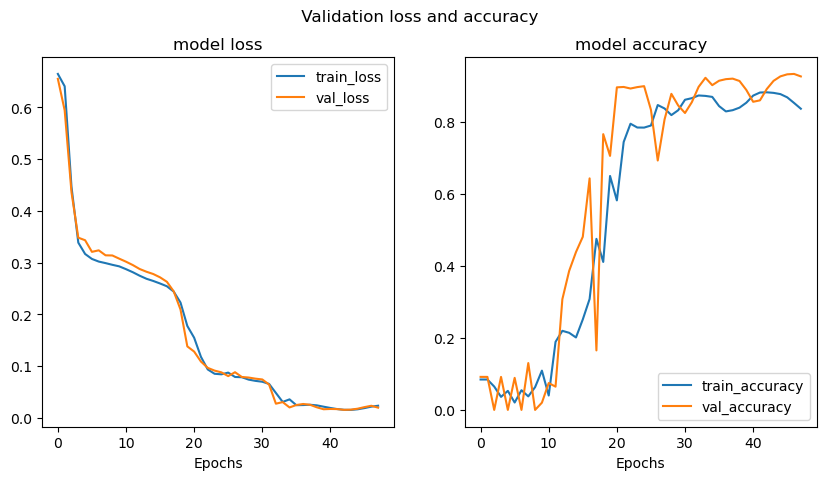

In [13]:
# Show the plot of the training process
plot_loss_acc(train_loss, val_loss,train_acc, val_acc)

### Step 4: Validate the results

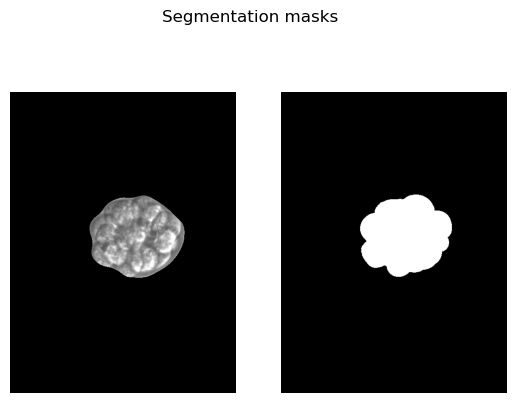

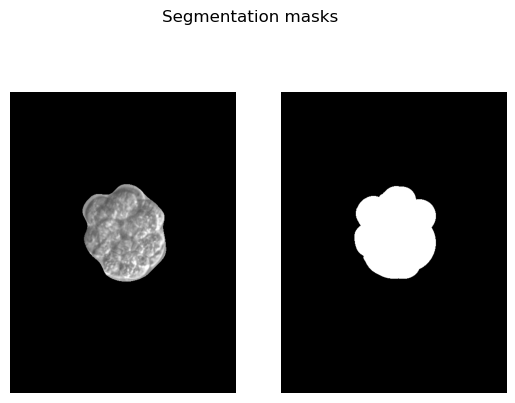

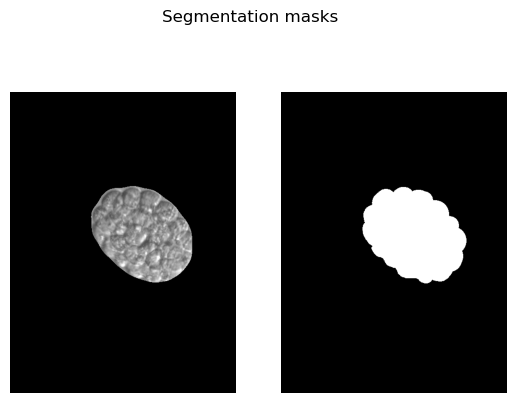

In [14]:
# Function to check the segmentation results to compare visually
def check_segmentation_results(model, dataset, threshold=0.5):
    model.eval()
    for image, mask in dataset:
        image = image[None, :,:,:]
        image = image.to(device)
        mask = mask.to(device)
        output = model(image)
        predicted_mask = get_segmentation_masks(output, threshold)
        show(image.cpu().squeeze()*predicted_mask.cpu().squeeze(), mask.cpu().squeeze(), title="Segmentation masks")


# Load the previous trained model    
unet = torch.load('trained-unet.pt', map_location=device)

# Predict and display the mask for the validation set
check_segmentation_results(unet, valid_dataset, 0.3)

Modify the function `check_segmentation_results` to include the IoU metric.

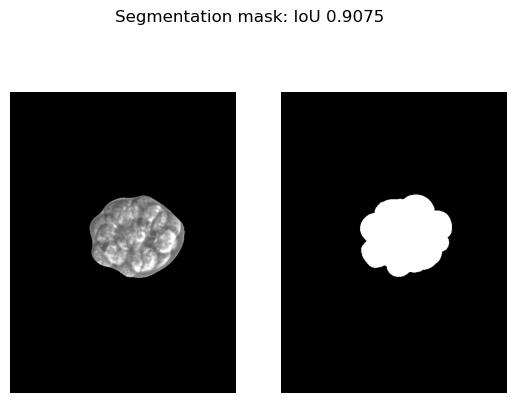

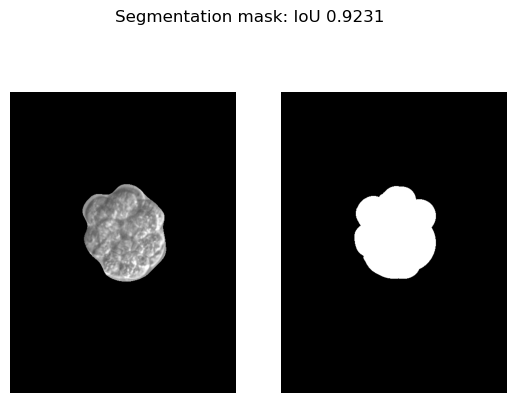

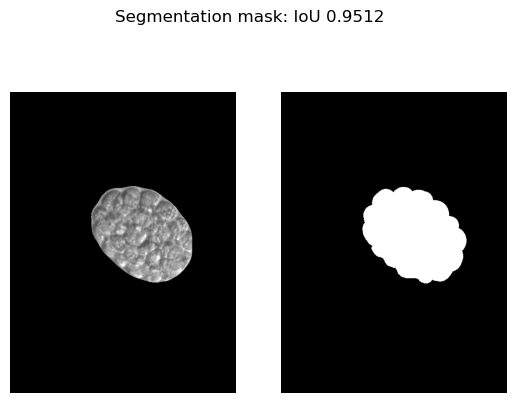

In [15]:
# Function to check the segmentation results to compare visually and with the IoU metric
def check_segmentation_results_with_acc(model, dataset, threshold=0.5):
    model.eval()
    for image, mask in dataset:
        image = image[None, :,:,:]
        image = image.to(device)
        mask = mask.to(device)
        output = model(image)
        
        predicted_mask = get_segmentation_masks(output, threshold)
        iou = compute_iou(predicted_mask, mask)
        show(image.cpu().squeeze()*predicted_mask.cpu().squeeze(), mask.cpu().squeeze(), title=f"Segmentation mask: IoU {iou:.4f}")

# Load the previous trained model    
unet = torch.load('trained-unet.pt', map_location=device)

# Predict and display the mask for the validation set
check_segmentation_results_with_acc(unet, valid_dataset, 0.3)

In this case we decide to try three different sets of data augmentation techniques in order to have a better experiment set to compare.

In [26]:
# Load images with data augmentation, in this cases using different types of rotation for the images
transf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=90),
        transforms.ToTensor()
    ])

augmented_dataset = EmbryoDataset("images", "masks", transf)

train_dataset, valid_dataset = torch.utils.data.random_split(augmented_dataset, [12, 3])

# Hyperparameters
BATCH_SIZE = 2
LR = 0.0001
N_INPUT_CHANNELS = 1
N_CLASSES = 1
THRESHOLD = 0.5
EPOCHS = 50

# Model
unet_augmented = UNet(N_INPUT_CHANNELS,N_CLASSES)
unet_augmented.to(device)

# Loss function (Binary Cross Entropy with Logits Loss)
bce_loss = nn.BCEWithLogitsLoss()

adam_optimizer = torch.optim.Adam(unet_augmented.parameters(), lr=LR)

train_loss, val_loss,train_acc, val_acc= train_model(unet_augmented, train_dataset, valid_dataset, device, adam_optimizer, bce_loss, BATCH_SIZE, EPOCHS, 'trained-unet-augmented_1.pt')

Epoch 1 - Train loss: 0.7160012821356455. Train acc: 0.08759277313947678 Val loss: 0.7058507998784384 Val acc: 0.07958984375
Saving model. New loss: 0.7058507998784384
Epoch 2 - Train loss: 0.680954655011495. Train acc: 0.08759087324142456 Val loss: 0.5803086161613464 Val acc: 0.07957139611244202
Saving model. New loss: 0.5803086161613464
Epoch 3 - Train loss: 0.44738438725471497. Train acc: 0.043184950947761536 Val loss: 0.3353288968404134 Val acc: 0.0
Saving model. New loss: 0.3353288968404134
Epoch 4 - Train loss: 0.35403598348299664. Train acc: 0.05836968123912811 Val loss: 0.3349168797334035 Val acc: 0.07961045950651169
Saving model. New loss: 0.3349168797334035
Epoch 5 - Train loss: 0.33442095418771106. Train acc: 0.02360774390399456 Val loss: 0.2974826395511627 Val acc: 0.0
Saving model. New loss: 0.2974826395511627
Epoch 6 - Train loss: 0.31452728311220807. Train acc: 0.06409502029418945 Val loss: 0.2849623163541158 Val acc: 0.0
Saving model. New loss: 0.2849623163541158
Epoch 

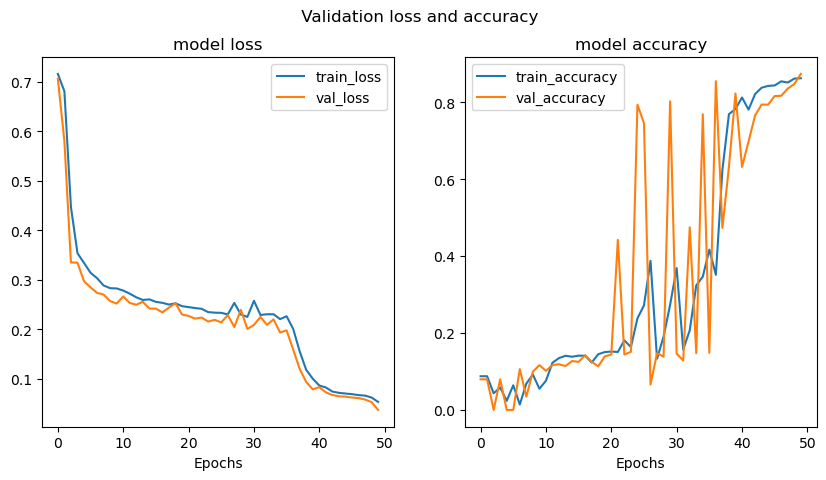

In [27]:
# Show the plot of the training process
plot_loss_acc(train_loss, val_loss,train_acc, val_acc)

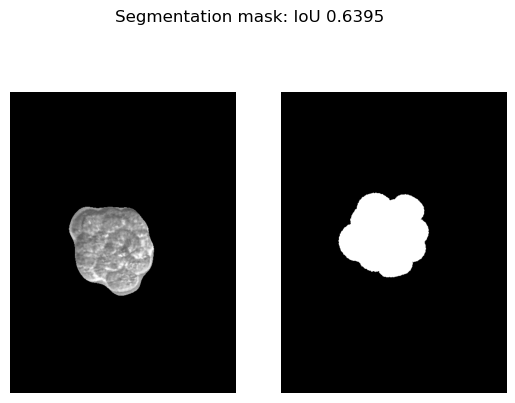

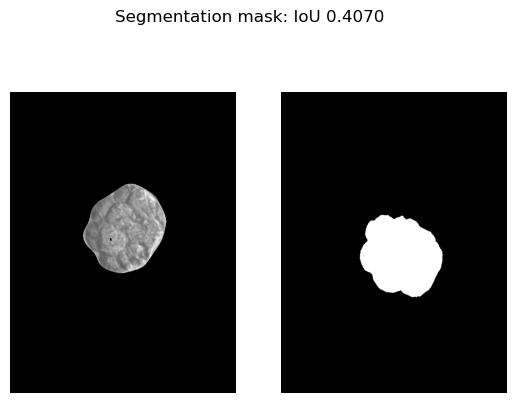

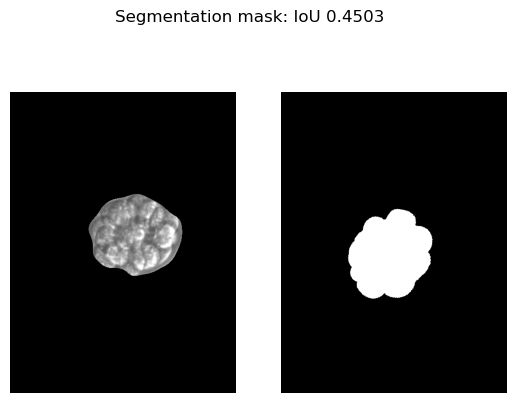

In [32]:
# Function to check the segmentation results to compare visually and with the IoU metric
# We add the transform in order to compare with data augmentation
def check_segmentation_results_with_acc(model, dataset, threshold=0.5, transform = None):
    model.eval()
    for image, mask in dataset:
        if transform != None:
            image = transform(image)  # Apply the same data augmentation transform used during training
        image = image[None, :,:,:]
        image = image.to(device)
        mask = mask.to(device)
        output = model(image)
        
        predicted_mask = get_segmentation_masks(output, threshold)
        iou = compute_iou(predicted_mask, mask)
        show(image.cpu().squeeze()*predicted_mask.cpu().squeeze(), mask.cpu().squeeze(), title=f"Segmentation mask: IoU {iou:.4f}")

# Load the previous trained model
unet = torch.load('trained-unet-augmented_1.pt', map_location=device)

# Predict and display the mask for the validation set
check_segmentation_results_with_acc(unet_augmented, valid_dataset, 0.5, transf)

In [19]:
# Load images with data augmentation, in this cases using different types of rotation for the images
transf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
        transforms.ToTensor()
    ])

augmented_dataset = EmbryoDataset("images", "masks", transf)

train_dataset, valid_dataset = torch.utils.data.random_split(augmented_dataset, [12, 3])

# Hyperparameters
BATCH_SIZE = 2
LR = 0.0001
N_INPUT_CHANNELS = 1
N_CLASSES = 1
THRESHOLD = 0.5
EPOCHS = 50

# Model
unet_augmented = UNet(N_INPUT_CHANNELS,N_CLASSES)
unet_augmented.to(device)

# Loss function (Binary Cross Entropy with Logits Loss)
bce_loss = nn.BCEWithLogitsLoss()

adam_optimizer = torch.optim.Adam(unet_augmented.parameters(), lr=LR)

train_loss, val_loss,train_acc, val_acc= train_model(unet_augmented, train_dataset, valid_dataset, device, adam_optimizer, bce_loss, BATCH_SIZE, EPOCHS, 'trained-unet-augmented_2.pt')

Epoch 1 - Train loss: 0.639238049586614. Train acc: 0.08545545488595963 Val loss: 0.630273719628652 Val acc: 0.08737412840127945
Saving model. New loss: 0.630273719628652
Epoch 2 - Train loss: 0.6152874330679575. Train acc: 0.08564642816781998 Val loss: 0.5679494341214498 Val acc: 0.08652344346046448
Saving model. New loss: 0.5679494341214498
Epoch 3 - Train loss: 0.43940984706083935. Train acc: 0.0664042979478836 Val loss: 0.4018693268299103 Val acc: 0.0
Saving model. New loss: 0.4018693268299103
Epoch 4 - Train loss: 0.332444762190183. Train acc: 0.03930263966321945 Val loss: 0.3458203375339508 Val acc: 0.08737412840127945
Saving model. New loss: 0.3458203375339508
Epoch 5 - Train loss: 0.3211948871612549. Train acc: 0.051947642117738724 Val loss: 0.32571476697921753 Val acc: 0.0
Saving model. New loss: 0.32571476697921753
Epoch 6 - Train loss: 0.3075866599877675. Train acc: 0.03499216213822365 Val loss: 0.314225693543752 Val acc: 0.08466155081987381
Saving model. New loss: 0.3142256

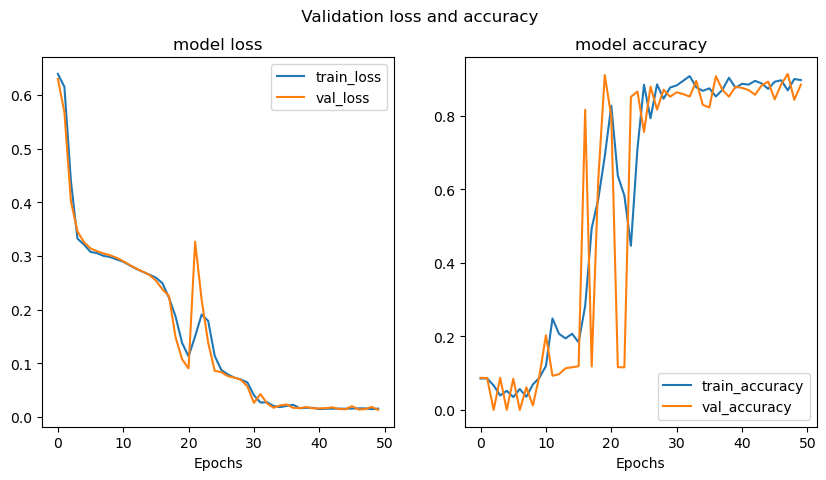

In [20]:
# Show the plot of the training process
plot_loss_acc(train_loss, val_loss,train_acc, val_acc)

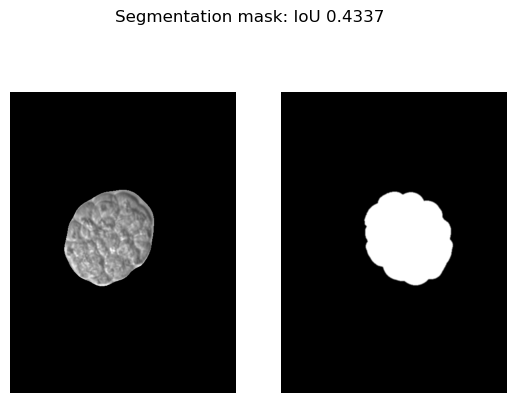

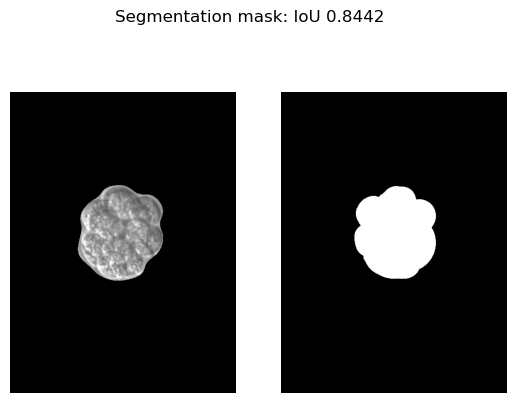

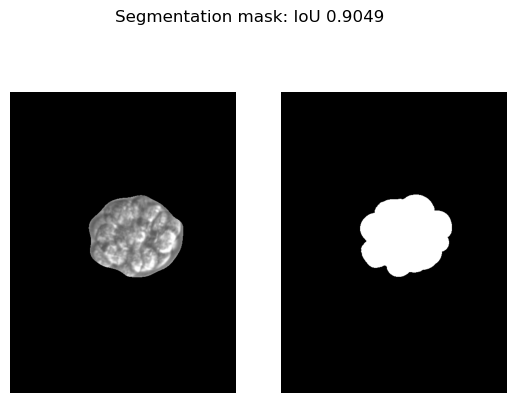

In [21]:
# Load the previous trained model
unet = torch.load('trained-unet-augmented_2.pt', map_location=device)

# Predict and display the mask for the validation set
check_segmentation_results_with_acc(unet_augmented, valid_dataset, 0.2, transf)

In [22]:
# Load images with data augmentation, in this cases using different types of rotation for the images
transf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
        transforms.ToTensor()
    ])

augmented_dataset = EmbryoDataset("images", "masks", transf)

train_dataset, valid_dataset = torch.utils.data.random_split(augmented_dataset, [12, 3])

# Hyperparameters
BATCH_SIZE = 2
LR = 0.0001
N_INPUT_CHANNELS = 1
N_CLASSES = 1
THRESHOLD = 0.5
EPOCHS = 50

# Model
unet_augmented = UNet(N_INPUT_CHANNELS,N_CLASSES)
unet_augmented.to(device)

# Loss function (Binary Cross Entropy with Logits Loss)
bce_loss = nn.BCEWithLogitsLoss()

adam_optimizer = torch.optim.Adam(unet_augmented.parameters(), lr=LR)

train_loss, val_loss,train_acc, val_acc= train_model(unet_augmented, train_dataset, valid_dataset, device, adam_optimizer, bce_loss, BATCH_SIZE, EPOCHS, 'trained-unet-augmented_3.pt')

Epoch 1 - Train loss: 0.6755823493003845. Train acc: 0.0844658687710762 Val loss: 0.6669483780860901 Val acc: 0.09043077379465103
Saving model. New loss: 0.6669483780860901
Epoch 2 - Train loss: 0.653363049030304. Train acc: 0.08488226681947708 Val loss: 0.6097285151481628 Val acc: 0.09043077379465103
Saving model. New loss: 0.6097285151481628
Epoch 3 - Train loss: 0.4580265631278356. Train acc: 0.07147324830293655 Val loss: 0.43132097522417706 Val acc: 0.0
Saving model. New loss: 0.43132097522417706
Epoch 4 - Train loss: 0.34234770635763806. Train acc: 0.044696200639009476 Val loss: 0.3556281526883443 Val acc: 0.09043077379465103
Saving model. New loss: 0.3556281526883443
Epoch 5 - Train loss: 0.3232101599375407. Train acc: 0.05079284682869911 Val loss: 0.3365596930185954 Val acc: 0.0
Saving model. New loss: 0.3365596930185954
Epoch 6 - Train loss: 0.30767641961574554. Train acc: 0.03705655038356781 Val loss: 0.32040579120318097 Val acc: 0.08890774101018906
Saving model. New loss: 0.3

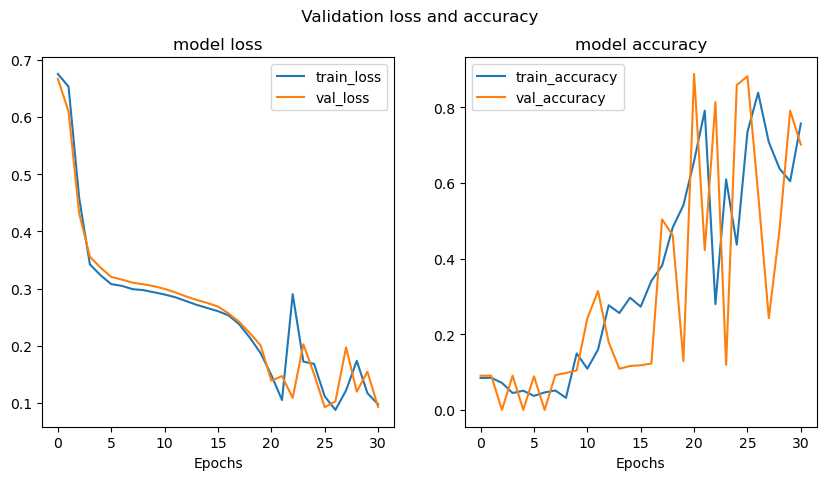

In [23]:
# Show the plot of the training process
plot_loss_acc(train_loss, val_loss,train_acc, val_acc)

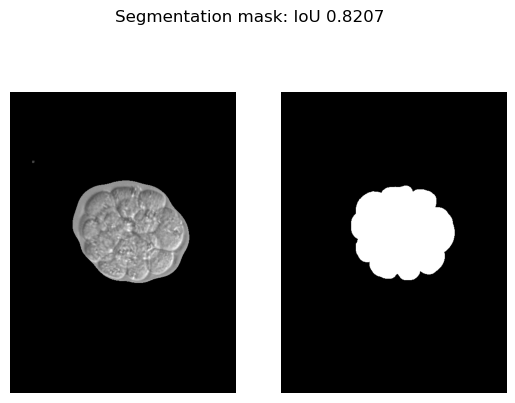

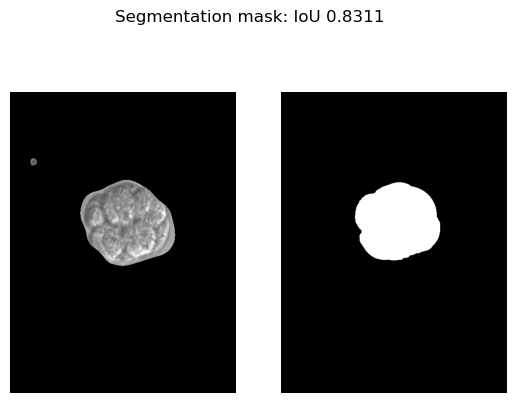

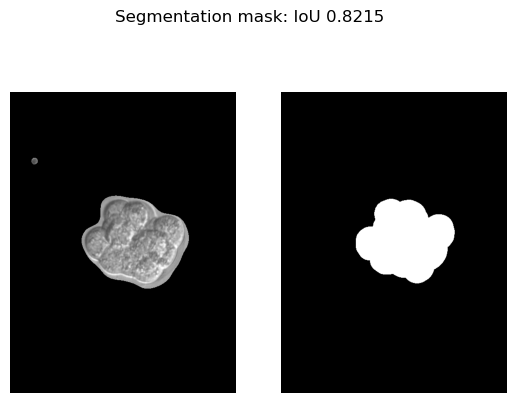

In [25]:
# Load the previous trained model
unet = torch.load('trained-unet-augmented_3.pt', map_location=device)

# Predict and display the mask for the validation set
check_segmentation_results_with_acc(unet_augmented, valid_dataset, 0.2, transf)